In [94]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer
from tqdm import tqdm
import numpy as np
import requests
from IPython.display import clear_output
import torch.nn as nn
import time
import matplotlib.pyplot as plt
from torch.quantization import quantize_dynamic
from wordcloud import WordCloud
import re
import string
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

OSError: dlopen(/opt/anaconda3/lib/python3.12/site-packages/torchtext/lib/libtorchtext.so, 0x0006): Symbol not found: __ZN3c105ErrorC1ENSt3__112basic_stringIcNS1_11char_traitsIcEENS1_9allocatorIcEEEES7_PKv
  Referenced from: <7E3C8144-0701-3505-8587-6E953627B6AF> /opt/anaconda3/lib/python3.12/site-packages/torchtext/lib/libtorchtext.so
  Expected in:     <69A84A04-EB16-3227-9FED-383D2FE98E93> /opt/anaconda3/lib/python3.12/site-packages/torch/lib/libc10.dylib

In [93]:
!pip install --upgrade torch torchtext

  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 MB 6.7 MB/s eta 0:00:0000:0100:01m
Using cached sympy-1.13.1-py3-none-any.whl (6.2 MB)
  Attempting uninstall: sympy
    Found existing installation: sympy 1.12
    Uninstalling sympy-1.12:
      Successfully uninstalled sympy-1.12
  Attempting uninstall: torch
    Found existing installation: torch 2.4.1
    Uninstalling torch-2.4.1:
      Successfully uninstalled torch-2.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.19.1 requires torch==2.4.1, but you have torch 2.6.0 which is incompatible.
stable-baselines3 2.1.0 requires gymnasium<0.30,>=0.28.1, but you have gymnasium 1.0.0 which is incompatible.
torchaudio 2.4.1 requires torch==2.4.1, but you have torch 2.6.0 which is incompatible.


In [53]:
# PARAMS
MAX_LENGTH = 400
BATCH_SIZE = 2
EPOCHS = 10
LEARNING_RATE = 2e-5
WARMUP_STEPS = 0.1

# Load data

In [84]:
path = "https://raw.githubusercontent.com/AmelNozieres/NLP_Generate_poems/master/Les_fleurs_du_mal_Baudelaire"
response = requests.get(path)
poems = response.text
corpus = poems.lower().split("\n")
corpus = [text.translate(str.maketrans('', '', string.punctuation)) for text in corpus]
vocab = poems.split(' ')
vocab = [element.strip() for element in vocab] 
chars = sorted(list(set(vocab)))
chars = [element.replace('\n', '') for element in chars]

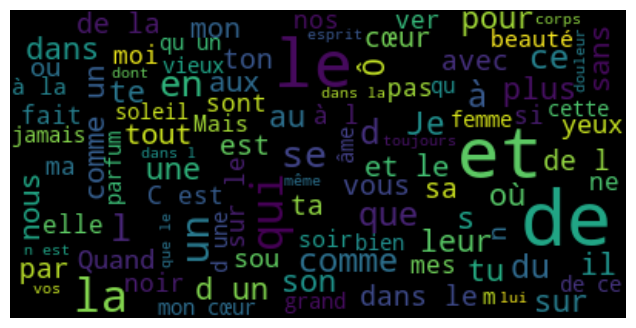

In [78]:
wordcloud = WordCloud(max_font_size=50, 
                      max_words=100, 
                      background_color="black").generate(poems) 

# Plotting the WordCloud 
plt.figure(figsize=(8, 4)) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off") 
plt.savefig("WordCloud.png") 
plt.show()

# Tokenizer

In [86]:
tokenizer = T5Tokenizer.from_pretrained("t5-small")
tokens = tokenizer(poems, return_tensors="pt")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Token indices sequence length is longer than the specified maximum sequence length for this model (53648 > 512). Running this sequence through the model will result in indexing errors


# DataLoader

In [88]:
class PoemDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]

        # Tokenisation
        encoding = self.tokenizer(text, 
                                  padding="max_length", 
                                  truncation=True, 
                                  max_length=self.max_length, 
                                  return_tensors="pt")

        # Retourne les IDs et le masque d'attention
        return {
            "input_ids": encoding["input_ids"].squeeze(0),  
            "attention_mask": encoding["attention_mask"].squeeze(0)
        }

In [89]:
dataset = PoemDataset(poems, tokenizer)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Model

In [82]:
len(max(chars))

10

In [100]:
class LSTMPoemGenerator(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers):
        super(LSTMPoemGenerator, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden):
        x = self.embedding(x)
        output, hidden = self.lstm(x, hidden)
        output = self.fc(output)
        return output, hidden

    def init_hidden(self, batch_size):
        return (torch.zeros(1, batch_size, self.hidden_dim), torch.zeros(1, batch_size, self.hidden_dim))


# Dataset

In [62]:
class PoetryDataset(Dataset):
    def __init__(self, corpus, tokenizer, max_length, device):
        self.input_ids = []
        self.attn_masks = []
        
        for line in tqdm(corpus):
            # Format text with hierarchical categories
            
            encodings = tokenizer(
                line,
                truncation=True,
                max_length=max_length,
                padding='max_length',
                return_tensors='pt'
            )
            
            self.input_ids.append(encodings['input_ids'][0].to(device))
            self.attn_masks.append(encodings['attention_mask'][0].to(device))
    
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attn_masks[idx],
        }

# Train the model

In [105]:
# Paramètres
seq_length = 50
batch_size = 32
embed_dim = 128
hidden_dim = 256
num_layers = 5
lr = 0.001

# Charger les données
dataset = PoetryDataset(corpus=corpus, tokenizer=tokenizer, max_length=len(max(chars))+1, device=device)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialiser le modèle
model = LSTMPoemGenerator(vocab_size=len(chars), embed_dim=embed_dim, hidden_dim=hidden_dim, num_layers=num_layers)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Entraînement
num_epochs = 10
for epoch in range(num_epochs):
    for inputs, targets in dataloader:
        inputs = torch.tensor([tokenizer.encode(text) for text in inputs], dtype=torch.long).to(device)
        targets = torch.tensor([tokenizer.encode(text) for text in targets], dtype=torch.long).to(device)
        hidden = model.init_hidden(batch_size)
        outputs, hidden = model(inputs, hidden)
        
        # Reshape pour correspondre aux dimensions de la loss
        loss = criterion(outputs.view(-1, len(vocab)), targets.view(-1))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


100%|██████████| 3575/3575 [00:00<00:00, 26121.19it/s]


RuntimeError: Expected hidden[0] size (5, 9, 256), got [1, 32, 256]

In [ ]:
def generate_text(model, start_text, length=50):
    model.eval()
    words = tokenizer(start_text)
    input_seq = torch.tensor([text_to_sequence(start_text)], dtype=torch.long)

    hidden = model.init_hidden(1)
    
    for _ in range(length):
        with torch.no_grad():
            output, hidden = model(input_seq, hidden)
            predicted_index = torch.argmax(output[:, -1, :], dim=-1).item()
            words.append(vocab.lookup_token(predicted_index))
        
        input_seq = torch.tensor([[predicted_index]], dtype=torch.long)

    return " ".join(words)

print(generate_text(model, "Dans le silence", length=50))

Epoch 1/10 | Batch 615/1788 | Loss: 6.1201 | Time: 468.60s


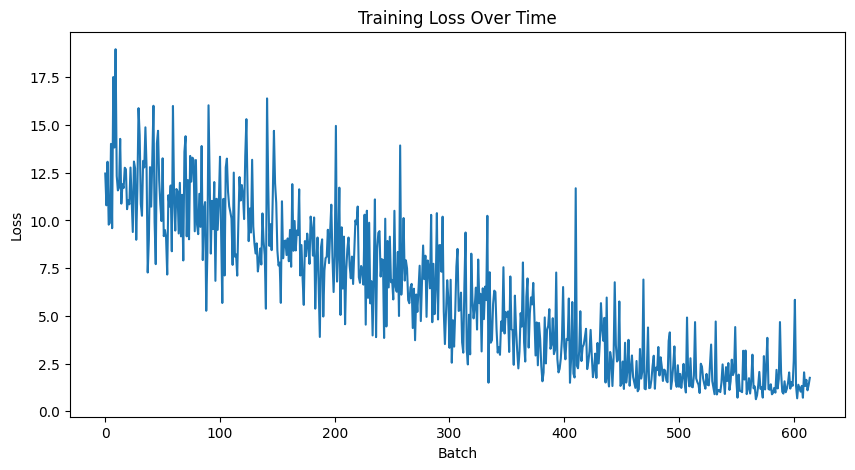

  0%|          | 0/10 [07:51<?, ?it/s]


KeyboardInterrupt: 

In [79]:
model.train()
total_start_time = time.time()
losses = []

for epoch in tqdm(range(EPOCHS)):
    epoch_start_time = time.time()
    total_loss = 0
    batch_times = []
    
    for batch_num, batch in enumerate(train_dataloader, 1):
        batch_start_time = time.time()
        
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        
        with torch.cuda.amp.autocast():
            outputs = model(
                input_ids,
                attention_mask=attention_mask,
                labels=input_ids
            )
            loss = outputs.loss
        
        total_loss += loss.item()
        losses.append(loss.item())
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        optimizer.zero_grad()
        
        # Display progress
        if batch_num % 5 == 0:
            clear_output(wait=True)
            elapsed_time = time.time() - epoch_start_time
            avg_loss = total_loss / batch_num
            print(f'Epoch {epoch+1}/{EPOCHS} | Batch {batch_num}/{len(train_dataloader)} | '
                  f'Loss: {avg_loss:.4f} | Time: {elapsed_time:.2f}s')
            
            # Plot loss curve
            plt.figure(figsize=(10, 5))
            plt.plot(losses)
            plt.title('Training Loss Over Time')
            plt.xlabel('Batch')
            plt.ylabel('Loss')
            plt.show()